In [33]:
import torch
import torch.nn as nn
import torchtext.vocab as vocab

In [34]:
# Mask 函数
def make_src_mask(self, src):
	print(src)
	src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
	print(src_mask)
	# (N, 1, 1, src_len)
	return src_mask.to(self.device)

In [35]:
# 测试句子
sents = [
    "The whether today is sunny",
    "I like my grandma's dog when I was a little boy, it was always happy when meeting me",
    "I love my grilfriend",
    "I love apples, which is my favorite friut"
]
sents_pd_id = []
sents_pd = []

# Padding
max_sent_len = 0
for s in sents:
    if len(s.split()) > max_sent_len:
        max_sent_len = len(s.split())
padding_word = ' PAD'
for s in sents:
    pad_n = max_sent_len - len(s.split())
    s += padding_word * pad_n
    sd = []
    for w in s.split():
        if w!= "PAD":
            sd.append(True)
        else:
            sd.append(False)
    sents_pd_id.append(sd)
    sents_pd.append(s)
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sents_pd_id = torch.tensor(sents_pd_id).unsqueeze(1).unsqueeze(2).to(device)
print(sents_pd)
print(sents_pd_id)


embdding_dim = 300
cache_dir = '.vector_cache/glove' # 使用glove 库
glove = vocab.GloVe(name='6B', dim=embdding_dim, cache=cache_dir) 

e = []
for s in sents_pd:
	embed = glove.get_vecs_by_tokens(s.split(), True).unsqueeze(0)
	e.append(embed)
sent_embedding = torch.cat((e[0], e[1], e[2], e[3]), dim=0).to(device)
print(sent_embedding.size())
print(sent_embedding.shape)


['The whether today is sunny PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD', "I like my grandma's dog when I was a little boy, it was always happy when meeting me", 'I love my grilfriend PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD', 'I love apples, which is my favorite friut PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD']
tensor([[[[ True,  True,  True,  True,  True, False, False, False, False, False,
           False, False, False, False, False, False, False, False]]],


        [[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
            True,  True,  True,  True,  True,  True,  True,  True]]],


        [[[ True,  True,  True,  True, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False]]],


        [[[ True,  True,  True,  True,  True,  True,  True,  True, False, False,
           False, False, False, False, False, False, False, False]]]])
torch.Size([4, 18, 300])
torch.Size([4, 18, 300])


# transformer encoder
 

In [36]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        # Get number of training examples
        # values.shape [N, seq_len, embedding_size]
        N = query.shape[0]

        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)  # (N, value_len, heads, head_dim)
        keys = self.keys(keys)  # (N, key_len, heads, head_dim)
        queries = self.queries(query)  # (N, query_len, heads, heads_dim)

        # Einsum does matrix mult. for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just how I like doing matrix multiplication & bmm

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim),
        # keys shape: (N, key_len, heads, heads_dim)
        # energy: (N, heads, query_len, key_len)

        # Mask padded indices so their weights become 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for
        # better stability
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
        # attention shape: (N, heads, query_len, key_len)
        torch.save(attention, "att.pth")

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # out after matrix multiply: (N, query_len, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.fc_out(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)

        return out


class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)
        torch.save(attention,"att_on_value.pth")

        # Add skip connection, run through normalization and finally dropout
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out


class Encoder(nn.Module):
    def __init__(
        self,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):

        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, embding_x, mask):
        N, seq_length, _ = embding_x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device) #[0,1,2,3,4...seq_length]
        out = self.dropout(
            (embding_x + self.position_embedding(positions))
        )

        # In the Encoder the query, key, value are all the same, it's in the
        # decoder this will change. This might look a bit odd in this case.
        for layer in self.layers:
            print(mask.shape)
            out = layer(out, out, out, mask)

        return out

# 模型使用

In [37]:

model = Encoder(
            embed_size = embdding_dim,
            num_layers = 1,
            heads = 6,
            device = device,
            forward_expansion = 4,
            dropout = 0,
            max_length = 100,
        )

out = model(sent_embedding, sents_pd_id)
print(out.shape)

torch.Size([4, 1, 1, 18])
torch.Size([4, 18, 300])


# 特性分析
- 句子相关性质分析
- Attention 结果分析

I like my grandma's dog when I was a little boy, it was always happy when meeting me
torch.Size([18, 300])
['I', 'like', 'my', "grandma's", 'dog', 'when', 'I', 'was', 'a', 'little', 'boy,', 'it', 'was', 'always', 'happy', 'when', 'meeting', 'me']


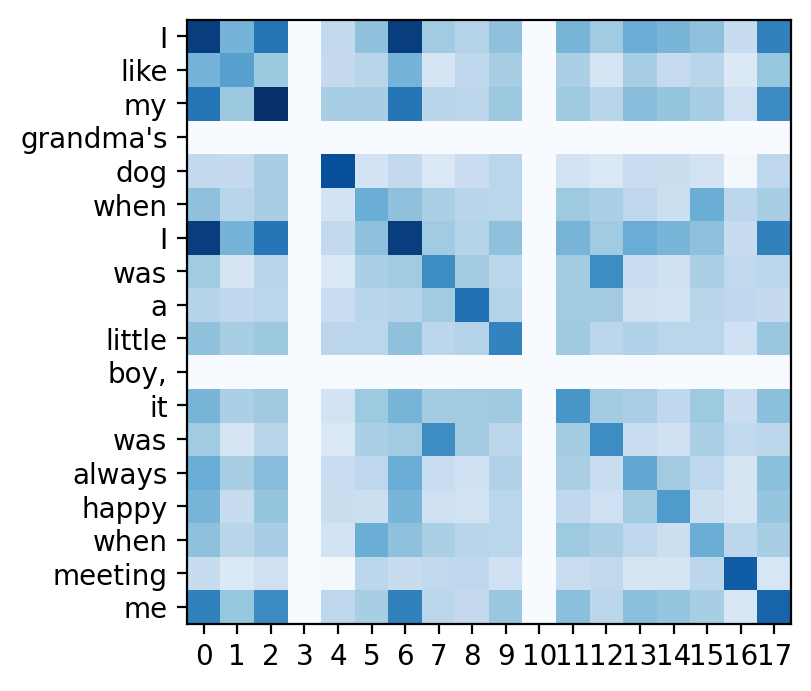

In [38]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
id = 1
s = sents[id]
sm = e[id][0]
print(s)
print(sm.shape)
ori_emb = sm @ sm.T
print(s.split())

x = MultipleLocator(10)    # x轴每10一个刻度
y = MultipleLocator(15)    # y轴每15一个刻度
# 设置刻度间隔
plt.figure(dpi=200)
plt.xticks(range(len(s.split())))
plt.yticks(range(len(s.split())), labels=s.split())
plt.imshow(ori_emb, cmap='Blues')

torch.Size([4, 18, 300])


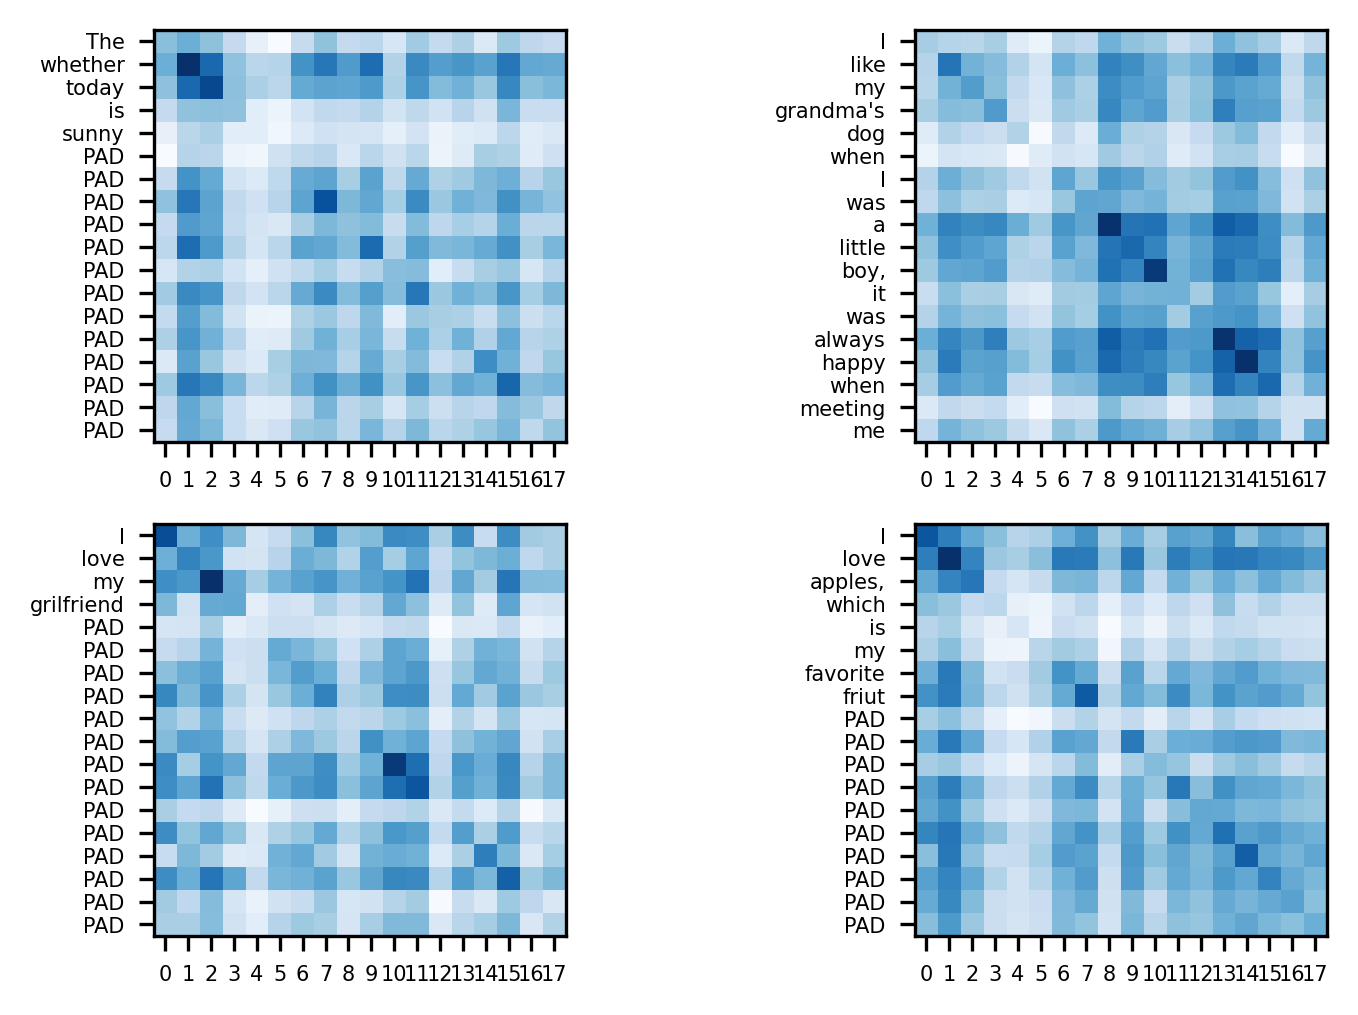

In [49]:
att_on_value = torch.load("att_on_value.pth")
print(att_on_value.size())
plt.figure(dpi=300)
for i in range(len(sents)):
    sent_att = att_on_value[i,:]
    cov = sent_att @ sent_att.T
    plt.subplot(2,2,i+1)
    plt.xticks(range(len(sents_pd[i].split())), fontsize=5)
    plt.yticks(range(len(sents_pd[i].split())), labels=sents_pd[i].split(), fontsize=5)
    cov = cov.detach().numpy()
    plt.imshow(cov, cmap='Blues')
    

torch.Size([4, 6, 18, 18])
torch.Size([6, 18, 18])


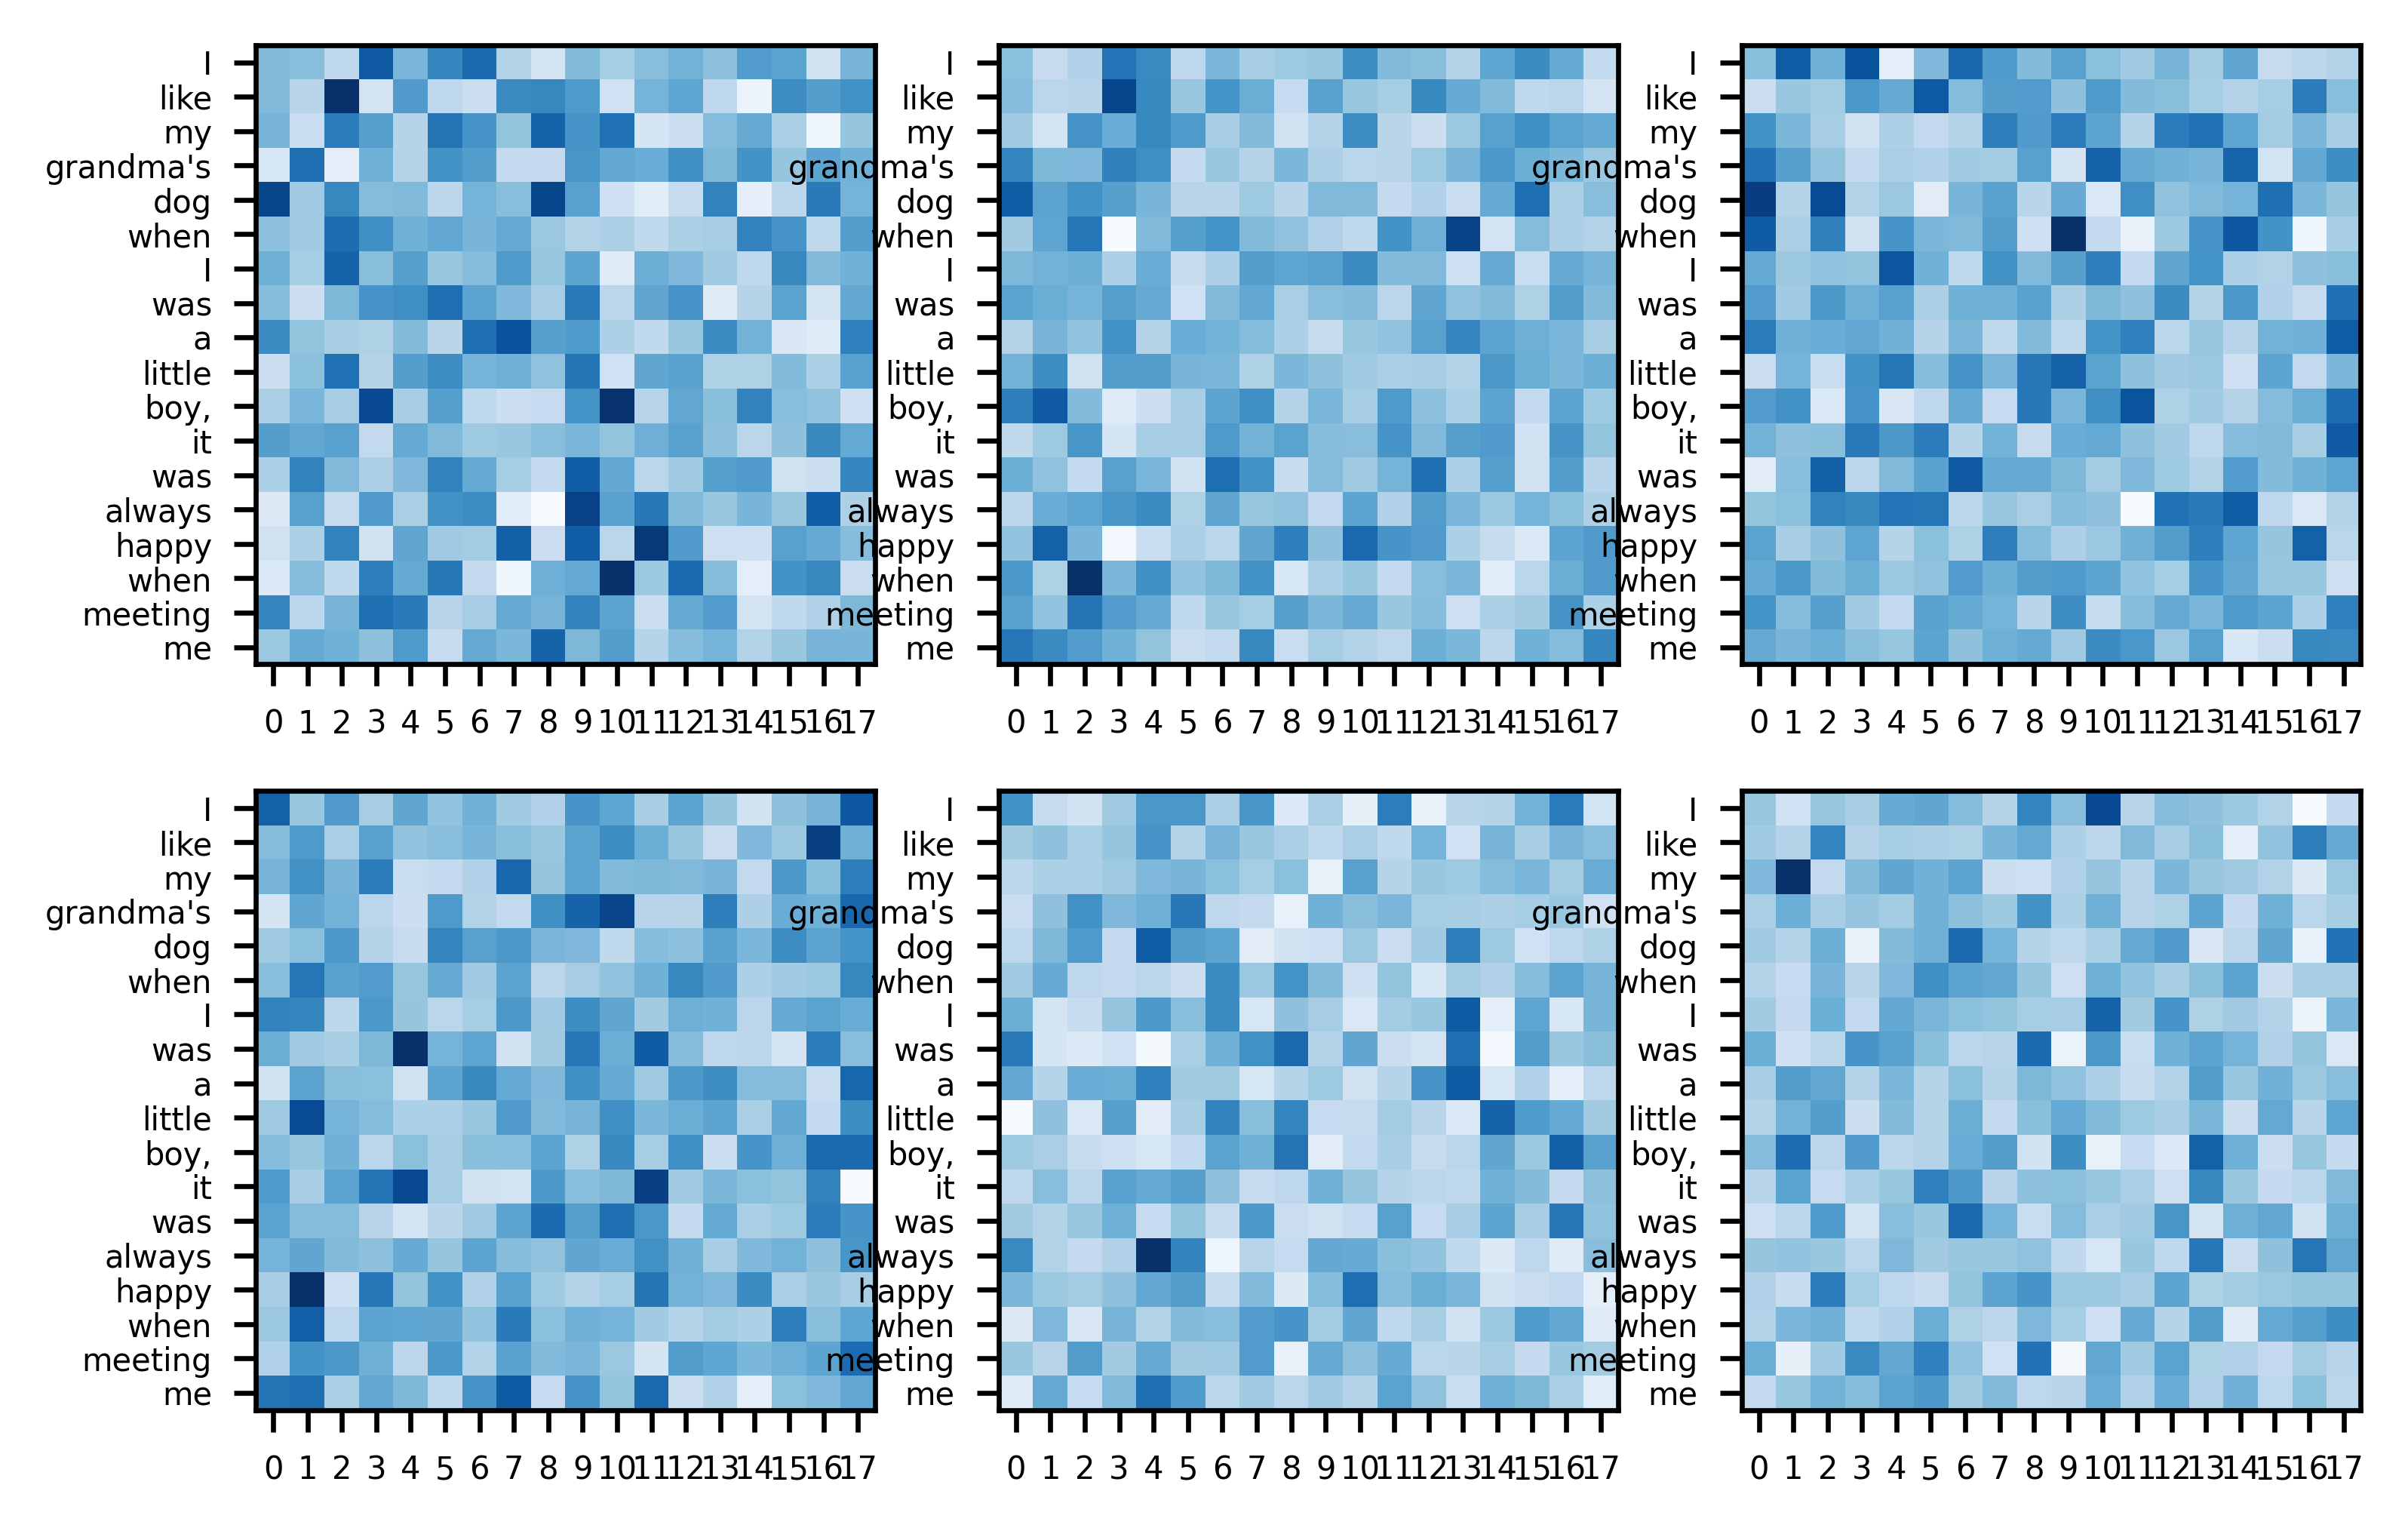

In [48]:
att = torch.load("att.pth")
print(att.shape)

id = 1
att = att[id,:,:,:]
print(att.shape)

heads = 6
plt.figure(dpi=600)
for i in range(heads):
    tem = att[i,:,:]
    plt.subplot(2, 3, i + 1)
    plt.xticks(range(len(sents_pd[id].split())), fontsize=5)
    plt.yticks(range(len(sents_pd[id].split())), labels=sents_pd[id].split(), fontsize=5)
    tem = tem.detach().numpy()
    plt.imshow(tem, cmap='Blues')
    
    